In [62]:
import pandas as pd 
from statsforecast import StatsForecast 
from statsforecast.models import (
    AutoETS,
    AutoMFLES,
    AutoTheta,
    CrostonOptimized,
    HoltWinters,
    WindowAverage,
    Naive,
    SeasonalNaive
)
from statsforecast.utils import ConformalIntervals
import tsforge as tsf 
import numpy as np
from pathlib import Path
import os 
import matplotlib.pyplot as plt
import sys

MODEL_ZOO = [
    Naive(),
    CrostonOptimized(),
    WindowAverage(window_size=4, alias="MA4"), # often a strong baseline in retail forecasting 
    SeasonalNaive(season_length=52, alias="SN52"), #predict last years value 
    HoltWinters(season_length=52, alias="HW52"), #holtwinters is a special, simplified case of ETS 
    AutoTheta(
        season_length=52,
        decomposition_type="multiplicative",
    ), # automatic selection of the best Theta model/method, use multiplicative seasonlity 
    
    AutoMFLES(test_size=13,
    n_windows=2,
    metric='mse',
    step_size=2,
    season_length=[13,52], # add multiple seasonal periods (quarterly, yearly)
    config={'changepoints': [False]}), # turn off changepoints to reduce training time 

    AutoETS(
        season_length=52,
        model="ZZZ", 
        damped=True,  # dampen the trend 
        phi=0.98,
    ), # AutoETS (Error,Trend,Seasonal) is a generalized State-Space Exponential Smoothing that automatically selects the best model
]

In [63]:
df = pd.read_parquet(
    "/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/data/output/m5_weekly.parquet"
)

In [64]:
# prepare statsforecast class

stat_fcst = StatsForecast(
    models=MODEL_ZOO,
    freq="W-SUN",  # set frequency to weekly
    n_jobs=-1,  # use all cpu cores
    fallback_model=Naive(),  # if we have any models that fail, fall back to naive
)


# Backtesting

* Cross-validation strategies for time series forecasting:
  * Rolling and Expanding Window: Here We Choose Rolling Window
    - this is an ideal choice for environments with ample data and volatile history

* Step Size = 1 (each fold advances by 1 time step)

* Windows = 5 (5-fold rolling window cross-validation)

* Horizon = 13
  
  

In [65]:
fill_df = tsf.fill_gaps(
    df=df,
    id_col='unique_id',
    time_col='ds',
    freq="W-SAT",
    start='global',
).assign(
    y = lambda df: df['y'].fillna(0)
)

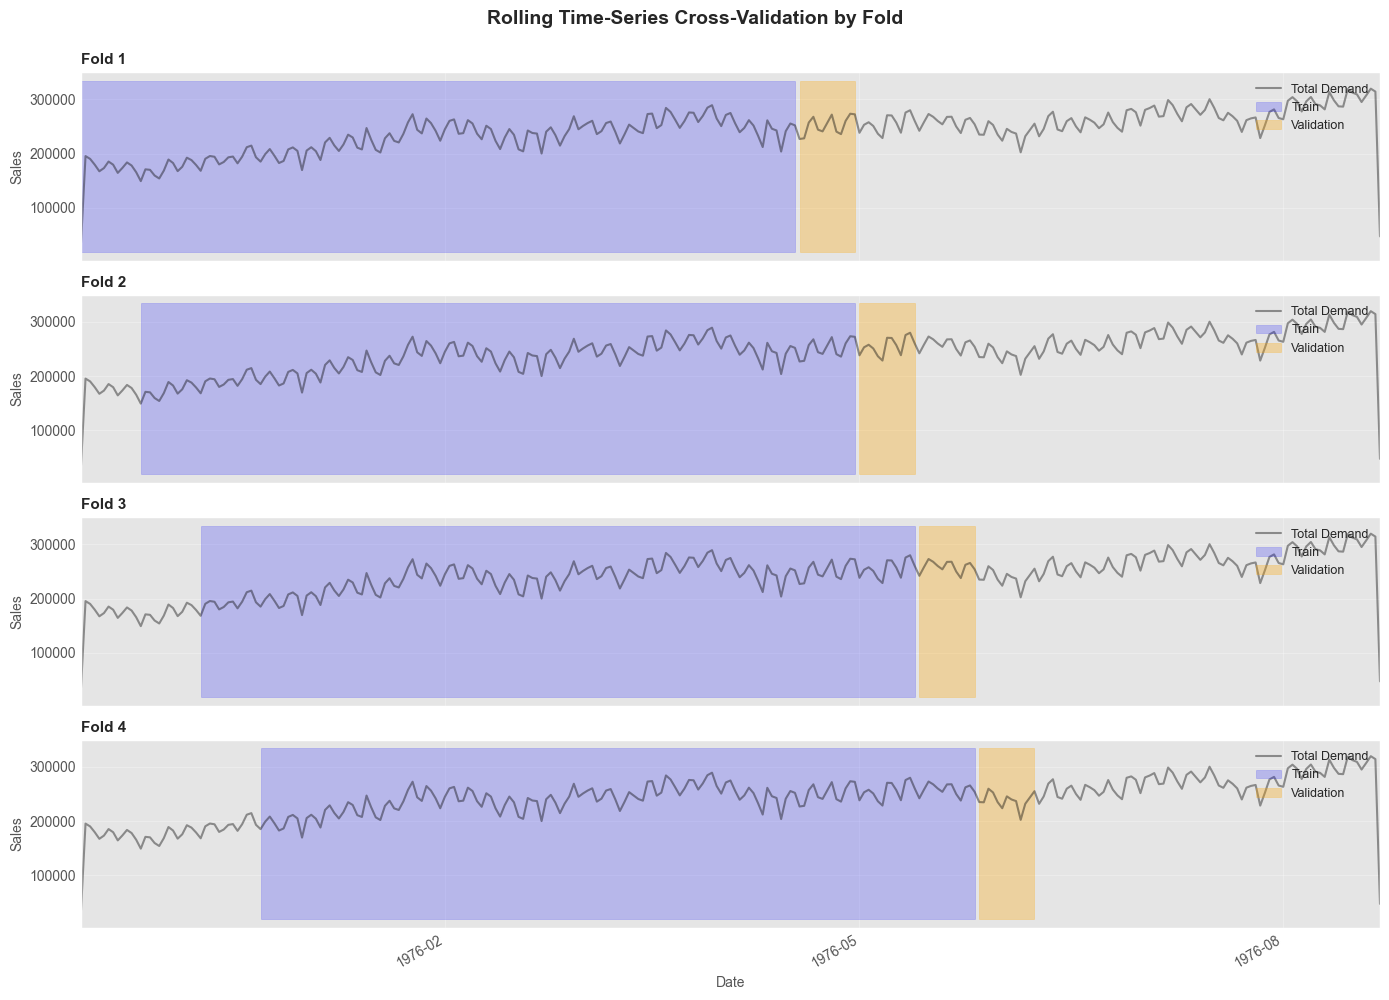

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use("ggplot")

HORIZON = 13
WINDOWS = 4
STEP_SIZE = 13
INPUT_SIZE = 52 * 3  # 3 years

dates = fill_df.sort_values("ds")["ds"].unique()
total_sales = fill_df.resample("W-SAT", on="ds")["y"].sum()

# Create subplots - one per fold
fig, axes = plt.subplots(WINDOWS, 1, figsize=(14, 10), sharex=True)

for i in range(WINDOWS):
    ax = axes[i]

    # Calculate indices
    tr_s, tr_e = i * STEP_SIZE, i * STEP_SIZE + INPUT_SIZE
    vl_s, vl_e = tr_e, tr_e + HORIZON

    # Map to dates
    d_tr_s, d_tr_e = dates[tr_s], dates[tr_e - 1]
    d_vl_s, d_vl_e = dates[vl_s], dates[vl_e - 1]

    # Plot total sales
    total_sales.plot(ax=ax, linewidth=1.5, color="black", alpha=0.4, label="Total Demand")

    # Get y-axis limits for fill_between
    ymin, ymax = ax.get_ylim()

    # Shade training period
    ax.fill_between(
        x=[d_tr_s, d_tr_e], y1=ymin, y2=ymax, color="blue", alpha=0.2, label="Train"
    )

    # Shade validation period
    ax.fill_between(
        x=[d_vl_s, d_vl_e], y1=ymin, y2=ymax, color="orange", alpha=0.3, label="Validation"
    )

    # Formatting
    ax.set_ylabel("Sales", fontsize=10)
    ax.set_title(f"Fold {i+1}", loc="left", fontweight="bold", fontsize=11)
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

# Format x-axis on bottom plot only
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

axes[-1].set_xlabel("Date", fontsize=10)
fig.suptitle(
    "Rolling Time-Series Cross-Validation by Fold", fontweight="bold", fontsize=14, y=0.995
)

plt.tight_layout()
plt.show()


In [67]:
# statsforecast makes this easy, under the hood it repeatedly is calling .forecast() in a "for" loop 


HORIZON = 13
WINDOWS = 4
STEP_SIZE = 13 # step by 13
INPUT_SIZE = 52*3 # 3 years 

cv_args = {
            # CV args.. 
            "h": HORIZON,
            "n_windows":WINDOWS,
            "step_size":STEP_SIZE,
            "input_size":INPUT_SIZE,
            
            # id cols 
            "id_col":"unique_id",
            "time_col":"ds",
            "target_col":"y",

            # probabalistic intervals args
            "prediction_intervals":ConformalIntervals(n_windows=2,h=HORIZON,method='conformal_distribution'),

            "level":[80,95]} # get probabalistic forecasts (to be used later.. )


cv_results = stat_fcst.cross_validation(
    **cv_args,
    df=fill_df,
)

/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools

In [68]:
n_ids = cv_results['unique_id'].nunique()

assert cv_results.shape[0] == (n_ids * (WINDOWS * HORIZON)), f"Expected {n_ids * (WINDOWS * HORIZON)} rows, got {cv_results.shape[0]}"

In [70]:
cv_results.to_parquet("statsforecast_backtest.parquet")